# Step One Photon Number Discrimination
* Determine the height thresholds for 2 level discrminator
* Obtain area histogram of traces
* Use area histogram to categorise photon number in traces

Output files:
List of n=1 traces
List of n=2 traces
Data file with:
    Height threshold
    Noise threshold
    n=1 integral center
    n=2 integral limits

In [1]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')

import math
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
from multiprocess import Pool

import seaborn

import trace_param as tp
import heralded_pulses_analysis as hpa
import thres_poiss
import thres
import pulse_utils as pu
reload(pu)

<module 'pulse_utils' from '/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode/pulse_utils.pyc'>

In [2]:
# Imports CW traces
directories = ['/mnt/disk0/home/jianwei_leejw/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/']

results_directory = './'
filelist=[]
for directory_name in directories:
    subfilelist = np.array(glob.glob(directory_name + '*.trc'))
    filelist.extend(subfilelist)
filelist = np.sort(np.array(filelist))
print len(filelist)

27119


# Get Approximate Height Threshold
Estimate threshold height to discriminate between electrical noise and photodetection events.

Gets maximum height of pulses, histograms the heights. 

Fit the distributions to a model to find the minimum crossing point between the distributions.

The resolution of this distribution will not be optimal due to the presence of partial pulses at the edges.

In [3]:
sample_size = int(1*len(filelist)) # number of samples to obtain height threshold from

In [4]:
reload(tp)
# max_heights = np.array([hpa.max_height(f) for f in tqdm.tqdm(filelist[:sample_size])])
max_heights = np.array(Pool(24).map(hpa.max_height, tqdm.tqdm(filelist[:sample_size])))

100%|██████████| 27119/27119 [00:04<00:00, 6361.18it/s]


In [5]:
bins = 200

In [6]:
height_distribution = np.histogram(max_heights, bins)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


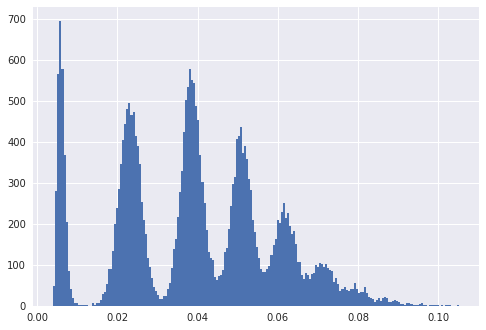

In [7]:
plt.figure()
plt.hist(max_heights,200);
plt.show()

In [8]:
frequencies ,binsv = thres.histogram(height_distribution)
binsv[np.where(frequencies==np.min(frequencies[(binsv>0.005)&(binsv<0.015)]))]

array([ 0.01291464,  0.01342033,  0.09736601,  0.1004002 ,  0.10141159,
        0.10343438,  0.10394007,  0.10444577])

In [9]:
height_distribution = np.histogram(max_heights[max_heights < 0.03], bins)

In [10]:
reload(thres_poiss)
height_th_approx = thres_poiss.thresholds_N_unnormed(height_distribution, 
                                            min_peak_sep=0.01, 
                                            weighted=True)[0]
print height_th_approx

[ 0.0058148   0.02305416]
0.0100922335228


In [11]:
height_th_approx = 0.0100922335228

[ 0.0058148   0.02305416]
[[Model]]
    (Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_'))
[[Variables]]
    A:              1.17141681 +/- 0.017008 (1.45%) (init= 2.16)
    n_bar:          1.19729435 +/- 0.022082 (1.84%) (init= 0.4)
    g0_sigma:       0.00081513 +/- 1.73e-05 (2.12%) (init= 0.002)
    sigma_p:        0.00265110 +/- 3.69e-05 (1.39%) (init= 0.002250791)
    g0_center:      0.00604270 +/- 2.24e-05 (0.37%) (init= 0.005814799)
    g1_center:      0.02316780 +/- 4.73e-05 (0.20%) (init= 0.02305416)
    g0_amplitude:   0.35377987 +/- 0.009353 (2.64%)  == 'A * exp(-n_bar)'
    g1_amplitude:   0.81763694 +/- 0.014205 (1.74%)  == 'A * (1-exp(-n_bar))'
    g1_sigma:       0.00265110 +/- 3.69e-05 (1.39%)  == 'sigma_p'
[[Correlations]] (unreported correlations are <  0.100)
    C(g0_sigma, g0_center)       =  0.153 



<IPython.core.display.Javascript object>


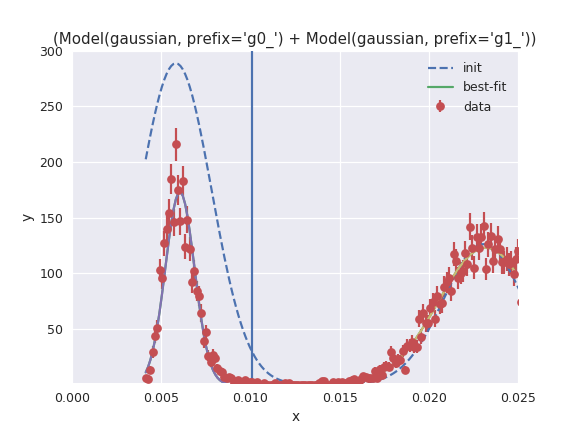

In [12]:
result_height_approx =  thres_poiss.gauss_fit_interp(height_distribution, 
                                  min_peak_sep=0.01,
                                  weighted=True)
print result_height_approx.fit_report()
frequencies ,bins = thres.histogram(height_distribution)
comps = result_height_approx.eval_components(x=bins)
%matplotlib notebook
plt.figure()
plt.title('Maximum Height Distribution (ignoring edges)\nSample size = {}'.format(sample_size))
result_height_approx.plot_fit()
plt.plot(bins,comps['g0_'])
plt.plot(bins,comps['g1_'])
plt.xlim(0,0.025)
plt.ylim(1,300)
plt.axvline(height_th_approx)
# plt.semilogy()
plt.show()

plt.figure()
plt.title('Maximum Height Distribution\nSample size = {}'.format(sample_size))
plt.bar(height_distribution[1][:-1],
        height_distribution[0], 
        width = np.diff(height_distribution[1])[0],
        align='center')
plt.axvline(height_th_approx, label='height_th_approx', linestyle='--')
plt.legend()
plt.show()

# Get Height Threshold (excluding partial pulses)
The maximum height of pulses at the edge of the acquisition window do not report the peak photodetection signal - they are obscured.

We use the approximate height obtained to initialise a two level discriminator.

The discriminator has 3 inputs:
* high_th: the level crossing that identifies the signal as a photodetection event
* low_th: the level crossing that turns the discriminator logic off
* offset: the number of data points that the discriminator window extends, in order to improve the signal to noise ratio

We use param_extr to calculate these values, 
(within discriminated windows, while ignoring partial traces)
* max height 
* rms 
* absolute area 

In [13]:
# Calculate offset value as a function of points
time_vector = pu.time_vector(filelist[0])
dt = np.diff(time_vector)[0]
offset = int(1700e-9/dt)
print offset

850


In [14]:
trace_parameters_approx = np.array(Pool(23).map(lambda f: hpa.param_extr(f,
                                   high_th = height_th_approx,
                                   low_th = 0,
                                   offset = offset),
                                  tqdm.tqdm(filelist[:sample_size])))

100%|██████████| 27119/27119 [00:10<00:00, 2583.28it/s]


In [15]:
max_heights_discriminated = trace_parameters_approx['height']

In [16]:
bins = 500
height_distribution_discriminated = np.histogram(max_heights_discriminated[max_heights_discriminated<0.03], bins)

In [17]:
frequencies ,binsv = thres.histogram(height_distribution_discriminated)
binsv[np.where(frequencies==np.min(frequencies[(binsv>0.0075)&(binsv<0.0125)]))]

array([ 0.00424641,  0.00906824,  0.00912009,  0.00937933,  0.00943118,
        0.00948302,  0.00953487,  0.00958672,  0.00963857,  0.00979411,
        0.00984596,  0.0098978 ,  0.01005335,  0.01015704,  0.01020889,
        0.01026074,  0.01031259,  0.01036443,  0.01046813,  0.01051998,
        0.01057182,  0.01062367,  0.01072737,  0.01077922,  0.01083106,
        0.01088291,  0.01093476,  0.01098661,  0.01103845,  0.0110903 ,
        0.01114215,  0.011194  ,  0.01124584,  0.01129769,  0.01134954,
        0.01145324,  0.01150508,  0.01155693,  0.01160878,  0.01166063,
        0.01171247,  0.01176432,  0.01181617,  0.01186802,  0.01197171,
        0.01202356,  0.01207541,  0.01212726,  0.0121791 ,  0.01223095,
        0.0122828 ,  0.01233465,  0.01238649,  0.01243834,  0.01249019,
        0.01254204,  0.01259388,  0.01264573,  0.01269758,  0.01274943,
        0.01280128,  0.01285312,  0.01290497,  0.01295682,  0.01300867,
        0.01306051,  0.01311236,  0.01316421,  0.01321606,  0.01

In [18]:
height_distribution_discriminated = np.histogram(max_heights_discriminated[max_heights_discriminated<0.03], bins)

In [19]:
reload(thres_poiss)

result_height =  thres_poiss.gauss_fit_interp(height_distribution_discriminated, 
                                  min_peak_sep=0.01,
                                  weighted=True)

height_th = thres_poiss.thresholds_N_unnormed(height_distribution_discriminated, 
                                            min_peak_sep=0.01, 
                                            weighted=True)
print result_height.fit_report()
height_th = height_th[0]
height_th

[ 0.00549075  0.02384483]
[ 0.00549075  0.02384483]
[[Model]]
    (Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_'))
[[Variables]]
    A:              0.43267384 +/- 0.006939 (1.60%) (init= 0.93)
    n_bar:          1.17553305 +/- 0.024017 (2.04%) (init= 0.4)
    g0_sigma:       0.00079124 +/- 1.79e-05 (2.26%) (init= 0.002)
    sigma_p:        0.00254533 +/- 3.93e-05 (1.54%) (init= 0.002250791)
    g0_center:      0.00605518 +/- 2.38e-05 (0.39%) (init= 0.005490751)
    g1_center:      0.02316404 +/- 5.02e-05 (0.22%) (init= 0.02384483)
    g0_amplitude:   0.13354668 +/- 0.003859 (2.89%)  == 'A * exp(-n_bar)'
    g1_amplitude:   0.29912715 +/- 0.005766 (1.93%)  == 'A * (1-exp(-n_bar))'
    g1_sigma:       0.00254533 +/- 3.93e-05 (1.54%)  == 'sigma_p'
[[Correlations]] (unreported correlations are <  0.100)
    C(g0_sigma, g0_center)       =  0.163 



0.010157043132980799

In [20]:
# frequencies ,bins = thres.histogram(height_distribution_discriminated)
comps = result_height.eval_components(x=binsv)

<IPython.core.display.Javascript object>


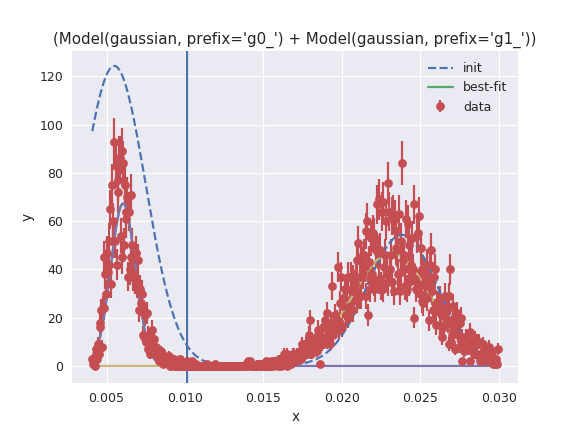

In [21]:
%matplotlib notebook
plt.figure()
plt.title('Maximum Height Distribution (ignoring edges)\nSample size = {}'.format(sample_size))
result_height.plot_fit()
plt.plot(binsv,comps['g0_'])
plt.plot(binsv,comps['g1_'])
# plt.xlim(0.006,0.025)
# plt.ylim(1,100)
plt.axvline(height_th)
# plt.semilogy()
plt.show()

In [22]:
height_th = 0.010157043132980799

In [23]:
# t = 0.0079408483085594457 #threshold using likelihood
t = height_th #threshold using posterior
thres_bin = hpa.find_idx(bins,t)
noise = int(np.sum(comps['g0_'][thres_bin:]))
signal_lost = int(np.sum(comps['g1_'][:thres_bin]))
signal_total = int(np.sum(comps['g1_']))
print noise, signal_lost, signal_total

2560 0 5748


In [24]:
np.savetxt('max_heights_discriminated.dat',max_heights_discriminated)
np.savetxt('pnr_height.dat',thres.histogram(height_distribution_discriminated))
np.savetxt('g0_component.dat',comps['g0_'])
np.savetxt('g1_component.dat',comps['g1_'])
with open('pnr_height_readme.dat','w+') as fp:
    fp.write('height_th = {}\n samples = {}'.format(height_th,sample_size))
fp.close()

# Calculate trace parameters with height threshold (obtained excluding partial pulses)
* Computes trace parameters for ALL traces
* Speeds up tasks with multiprocessing

In [25]:
# Import/Set discriminator settings
# if os.path.isfile(results_directory + 'disc_settings.dat'):
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)

IOError: [Errno 2] No such file or directory: './disc_settings.dat'

In [26]:
# saves discriminator characteristics
np.savetxt(results_directory + 'disc_settings.dat', [height_th, offset],header='height_th\toffset')

In [27]:
print height_th, offset

0.010157043133 850


In [28]:
reload(hpa)
tasks = tqdm.tqdm(filelist[:])
def param_extr_poolable(f):
    """poolable version of parameter extractor"""
    return hpa.param_extr(f,
                   high_th = height_th,
                   low_th = 0,
                   offset = offset)

  0%|          | 0/27119 [00:00<?, ?it/s]

In [29]:
# reload(hpa)
reload(pu)
if os.path.isfile(results_directory + 'trace_params.dat'):
    trace_parameters = np.genfromtxt(results_directory + 'trace_params.dat', names=True)
else:
    trace_parameters = np.array(Pool(23).map(param_extr_poolable, tasks))
# trace_parameters = np.array(Pool(23).map(param_extr_poolable, tasks))

100%|██████████| 27119/27119 [00:12<00:00, 2240.67it/s]


In [30]:
print trace_parameters.dtype.names
area = trace_parameters['area_win_abs']
numedges = trace_parameters['numedges']

('filename', 'numedges', 'area_win', 'area_win_abs', 'height', 'rms', 'bg_mv')


In [31]:
e1 = numedges==1
e2 = numedges==2
e3 = numedges==3
a1 = area[e1]
a2 = area[e2]
a3 = area[e3]
np.savetxt('AbsArea_1Edge.dat',a1)
np.savetxt('AbsArea_2Edge.dat',a2)
np.savetxt('AbsArea_3Edge.dat',a3)

<IPython.core.display.Javascript object>


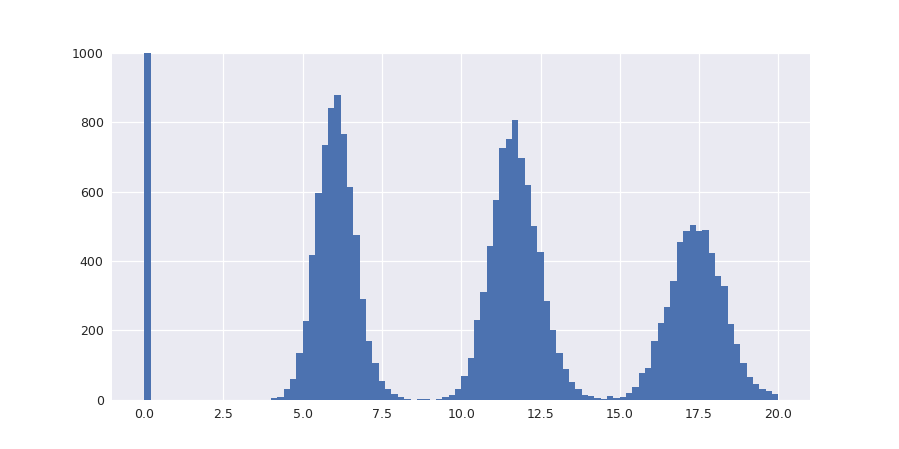

In [32]:
plt.figure(figsize=(10,5))
plt.hist(area,100,range=(0,20))
# plt.hist(area,100,range=(2.5,20),label='all',alpha=0.5)
# plt.hist(a1,100,range=(2.5,20),label='1edge',alpha=0.5);
# plt.hist(a2,100,range=(2.5,20),label='2edges');
# plt.hist(a3,100,range=(2.5,20),label='3edges');
plt.ylim(1,1000)
# plt.semilogy()
plt.show()

In [33]:
trace_parameters['filename'][0]

u'/mnt/disk0/home/jianwei_leejw/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/C2_double_90ns_avg_100_00000.trc'

# Fit Area Distribution
* Select traces with number of edges = 1: we are only interested in traces occuring within the disrciminator window, traces which are overlapped.
* Threshold (th01) between n=0, n=1 determined by seeking the minimum between the two distributions.
* N >= 1 distributions fitted with Gaussian multiplied by Poisson coefficients
* N=1 distribution is selected to be within 2 sigmas of its distribution.
* N=2 distribution selected to be within th12 and th23

In [34]:
bins = 200
lims = (0,20)
area_distribution = np.histogram(area, bins) 

In [35]:
# Count n=1 traces
# frequencies ,binsv = thres.histogram(area_distribution)
# p1 = np.sum(f[(binsv>2.5)&(binsv<9.45)])/400000
# print 'p(n=1) =', p1

In [36]:
def nbar(frequencies,bins,height_th):
    """
    nbar estimate from n0 population.
    initially, plan was to get n0 from height distribution: -np.log((40000-9649)/40000)
    however, the nbar obtained from the n=1 population from the area distribution (with only 1 edge) 
    predicted an n=2 population from the area distribution (with both 1 and 2 edges)
    """
    n0 = np.sum(frequencies[bins<=height_th])
    n = np.sum(frequencies)
    print n0/n
    return -np.log(n0/n)
def poiss(k,nbar):
    return nbar**k*np.exp(-nbar)/math.factorial(k)

In [37]:
# use p(n=1) from the area distribution[numedges==1] to estimate nbar
print poiss(1,0.2525)
print poiss(2,0.2525)*400000

0.196156193742
9905.88778397


In [38]:
# %matplotlib notebook
# plt.figure()
# plt.hist(area[numedges==1],100,range=(1,20),alpha=0.2,normed=False,label='1 edge')
# plt.hist(area[(numedges==1)|(numedges==2)],100,range=(1,20),alpha=0.2,normed=False,label='1 or 2 edges')
# plt.hist(area[~((numedges==1)&(area<9.2))],100,range=(1,20),alpha=0.2,normed=False, label='less n=0,1')
# plt.ylim(1,200)
# plt.xlim(8,15)
# plt.legend()
# plt.show()

In [39]:
# print nbar(frequencies,bins,0.0097), poiss(2,0.253)*400000
# print -np.log((40000-9649)/40000)
# print poiss(1,0.253)

est peak pos = [  6.21717324  11.84223475  17.46729625  23.09235776  28.71741927
  34.63853664]
est peak hts = [1292 1149  735  428  157   73]
th01 = 3
poissonian probs from n=1,2...= [0.23853284424163204, 0.26709734479068958, 0.19938831155111594, 0.11163261136410596, 0.05000028265658793, 0.018662618948511404]


<IPython.core.display.Javascript object>


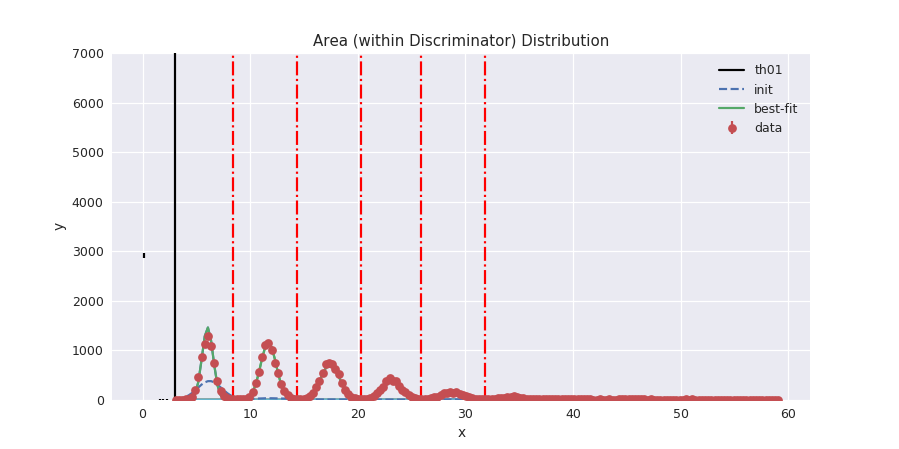

[[Model]]
    (((((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_')) + Model(gaussian, prefix='g6_'))
[[Variables]]
    n_bar:          2.23950161 (init= 0.2)
    A:              7827.71754 (init= 6460)
    Delta_E:        17.9396448 (init= 5)
    sigma_p:        0.51057761 (init= 1.125395)
    g1_center:      6.03513959 (init= 6.217173)
    g2_center:      11.6866208 (init= 11.84223)
    g3_center:      17.4203473 (init= 17.4673)
    g4_center:      23.1500161 (init= 23.09236)
    g5_center:      28.7307514 (init= 28.71742)
    g6_center:      34.3239898 (init= 34.63854)
    g1_amplitude:   1867.16773  == 'A * exp(-n_bar) * n_bar**1 / factorial(1)'
    g2_amplitude:   2090.76257  == 'A * exp(-n_bar) * n_bar**2 / factorial(2)'
    g3_amplitude:   1560.75538  == 'A * exp(-n_bar) * n_bar**3 / factorial(3)'
    g4_amplitude:   873.828550  == 'A * exp(-n_bar) * n_bar**4 / factori

In [40]:
%matplotlib notebook
reload(thres)
result = thres.gauss_fit_poiss_ph_region(area_distribution,
                                         th01 = 3,
                                          min_peak_sep=5, 
                                          threshold=5e-2, 
                                          weighted=True,
                                          plot=True)
result.plot_fit()
plt.title('Area (within Discriminator) Distribution')
plt.ylim(1,7000)
# plt.xlim(2.35,22)
# plt.semilogy()
plt.show()

plt.figure()
plt.hist(area_prev[:50000],100,histtype='step',label='previous');
plt.hist(area_prev[-50000:],100,histtype='step');
plt.ylim(0,500)
plt.xlim(6,15)
plt.legend()
plt.show()

In [41]:
print result.best_values['g2_center']/result.best_values['g1_center']
print result.best_values['g3_center']/result.best_values['g1_center']

1.93642924582
2.88648622919


In [42]:
reload(thres)
thresholds_unnormed = thres.thresholds_N_unnormed(area_distribution,
                                          th01=3,
                                          min_peak_sep=5, 
                                          threshold=5e-2, 
                                          weighted=True,
                                          )
print thresholds_unnormed
ax = plt.gca(); map(lambda t: ax.axvline(t, linestyle='-.',color='red'),thresholds_unnormed); #plot thresholds in area distribution

est peak pos = [  6.21717324  11.84223475  17.46729625  23.09235776  28.71741927
  34.63853664]
est peak hts = [1292 1149  735  428  157   73]
th01 = 3
poissonian probs from n=1,2...= [0.23853284424163204, 0.26709734479068958, 0.19938831155111594, 0.11163261136410596, 0.05000028265658793, 0.018662618948511404]
[8.4375922583062106, 14.358709632556184, 20.279827006806155, 25.904888512343629, 31.826005886593602]


In [43]:
th01 = 3

In [44]:
frequencies ,bins = thres.histogram(area_distribution)
comps = result.eval_components(x=bins)

In [45]:
t = thresholds_unnormed[0] #threshold
thres_bin = hpa.find_idx(bins,t)
noise = int(np.sum(comps['g1_'][thres_bin:]))
signal_lost = int(np.sum(comps['g2_'][:thres_bin]))
signal_total = int(np.sum(comps['g2_']))
print noise, signal_lost, signal_total

0 0 7062


## Save PNR

In [46]:
np.savetxt('pnr_area_disc.dat',thres.histogram(area_distribution))
np.savetxt('g1_area_component.dat',comps['g1_'])
np.savetxt('g2_area_component.dat',comps['g2_'])
np.savetxt('g3_area_component.dat',comps['g3_'])
with open('pnr_area_readme.dat','w+') as fp:
    fp.write('a_th01 = {}\n a_th12 = {}\n a_th23 = {}'.format(th01,thresholds_unnormed[0],thresholds_unnormed[1]))
fp.close()

In [47]:
bins = 200
area_above_threshold = trace_parameters['area_win']
area_above_threshold_distribution = np.histogram(area_above_threshold, bins) 
frequencies, bins = thres.histogram(area_above_threshold_distribution)
np.savetxt('pnr_area_above_th.dat',thres.histogram(area_above_threshold_distribution))

# Photon Number Masks
* creates mask for photon numbers

In [48]:
mask_0ph = (area < th01)

In [49]:
# single photon mask: 
# within 2 std deviations of mean single-photon area to exclude outliers corresponding to more false positives 
mask_1ph = (area > result.best_values['g1_center']-2*result.best_values['g1_sigma'])&\
           (area < result.best_values['g1_center']+2*result.best_values['g1_sigma'])
# two photon mask:
# within thresholds corresponding to minimal overlap between n=1 and n=3 photons
mask_2ph = (area > thresholds_unnormed[0])&(area < thresholds_unnormed[1])

In [50]:
print sum(mask_2ph)

7160


# Save filelists and fit results

In [51]:
# saves filelist of n = 0, 1, 2 photons
hpa.append2file(results_directory + 'filelist_zero_photon.dat',"\n".join(filelist[mask_0ph]))
hpa.append2file(results_directory + 'filelist_single_photon.dat',"\n".join(filelist[mask_1ph]))
hpa.append2file(results_directory + 'filelist_two_photon.dat',"\n".join(filelist[mask_2ph]))

In [52]:
# saves fit results of area distribution
f = open(results_directory + 'area_distribution_lmfit_result.dat','wb')
pickle.dump(result,f)
f.close()

In [53]:
# saves thresholds(point of minimal overlap) between number distributions 
th_areas_from_min_overlap = np.array(np.insert(thresholds_unnormed,0,th01))
np.savetxt(results_directory+'th_areas_from_min_overlap.dat',th_areas_from_min_overlap,header='\t'.join(['th01,th12,th23']))

In [54]:
# saves whole filelist and trace parameters for future reference
hpa.append2file(results_directory + 'filelist.dat',"\n".join(filelist))
np.savetxt(results_directory + 'trace_params.dat',
           trace_parameters,
           header="\t".join(trace_parameters.dtype.names),
           fmt=('%s %d %.18e %.18e %.18e %.18e %.18e')
          )

In [55]:
# saves fit result of height distribution
g = open(results_directory + 'height_distribution_lmfit_result_height_th_{}.dat'.format(height_th),'wb')
pickle.dump(result_height,g)
g.close()

# Calculate RMS noise of n=0 traces

In [56]:
a = np.genfromtxt(results_directory + 'filelist_zero_photon.dat', delimiter='\n',dtype='string')

In [57]:
test = np.genfromtxt('trace_params.dat',
                    dtype=[('filename', 'U256'),
                           ('numedges', 'int8'),
                        ('area_win', 'float64'),
                        ('area_win_abs', 'float64'),
                       ('height', 'float64'),
                       ('rms', 'float64'),
                       ('bg_mv', 'float64')
                       ])

In [58]:
print test[0]

(u'/mnt/disk0/home/jianwei_leejw/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/C2_double_90ns_avg_100_00000.trc', 1,  5.92881535,  5.96709586,  0.02264478,  0.00412419,  0.)


In [59]:
rms = np.mean(trace_parameters['rms'][mask_0ph])
np.savetxt(results_directory + 'rms.dat', 
           [rms],
           header='rms')
print rms

0.00188088880294
